## **Spindle detection**

#### **Spindles calculation**
**<ul>Define 2 seconds windows</ul>**
**<ul>Animal movement using 2.5 cm/s </ul>**
**<ul>Theta/delta power ration > 2 </ul>**

#### **Import libraries**

In [1]:
import sys  
sys.path.insert(0, 'D:/Beths/')
import os
import re
import math
import pandas as pd
import numpy as np
import yasa
import mne
from mne.filter import filter_data, resample
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
from pandas_profiling import ProfileReport


## Import from my files
from data_lfp import mne_lfp_Axona, load_lfp_Axona
from data_pos import RecPos
from bandPower import *

import warnings
warnings.filterwarnings('ignore')

#### **Reference papers**

##### **Detection of slow-wave sleep, sharp-wave ripples and multi-unit activity bursts**

Paper: Coordinated Emergence of Hippocampal Replay and Theta Sequences during Post-natal Development: 
[https://www.sciencedirect.com/science/article/pii/S0960982219300065]

The brain states slow-wave sleep (SWS), rapid-eye movement sleep (REM) and awake movement were defined following [22
]. A multitaper power spectral density estimate of the hippocampal local field potential (LFP) was derived for **1.6 s windows** , overlapping by 0.8 s (MATLAB function ‘pmtm’). From this, power in the delta and theta bands were calculated in each window. As theta frequency changes during development [18
], theta and delta peak frequencies were calculated for each session, defined as the peak frequency of the fast Fourier transform of the LFP, in the bands 5-11Hz (theta) and 1.5-4Hz (delta). **Mean running speed for each 1.6 s bin was also estimated. In the absence of EMG recordings, we could not unequivocally discriminate between slow wave sleep and quiet immmobility, we therefore restricted all analyses to epochs termed ‘rest’.**

Rest was defined as epochs with running speed < 2.5cm/s , and theta/delta power ratio < 2 and waking movement as theta/delta power ratio > 2 and speed > 2.5cm/s. 
Sharp-wave ripples were detected by first filtering the LFP in the band 100-250Hz. 
The instantaneous power of the filtered LFP was then estimated by calculating the root mean square over 7ms intervals (MATLAB function ‘envelope’ with option ‘rms’). From all LFPs across tetrodes in the CA1 layer, the LFP whose power estimate had the highest standard deviation was then used to define ripple events, as 100ms windows around the peak power, whenever the power was greater than the 99th percentile of all powers in the trial (approximately equal to 4 standard deviations above the mean). Multi-unit activity (MUA) bursts were defined by binning all spikes from CS cells into 1ms bins and smoothing the resulting binned spike train with a Gaussian kernel (s.d. 10ms). MUA events were then defined as crossing of a threshold defined as 3 standard deviations above the mean of the smoothed spike train, with a duration from 100-750ms. Only MUA bursts which temporally overlapped (even in part) with SWR events were included in the replay analysis.

#### **Open Sleep Files**

In [2]:
df = pd.read_csv('data_scheme.csv')
sleep = df.loc[df.sleep == 1]
sleep_files = df.loc[df.sleep == 1, ['folder', 'filename']].agg('/'.join, axis=1).values

In [3]:
sleep_files = [file for file in sleep_files if 'awake' not in file.split('_')]
sleep_files = [file for file in sleep_files if 'awake.set' not in file.split('_')]
filenames = [r.strip().split('/')[-1] for r in sleep_files]
sleep = df[df.filename.isin(filenames)]
sleep_files = sleep.loc[sleep.sleep == 1, ['folder', 'filename']].agg('/'.join, axis=1).values

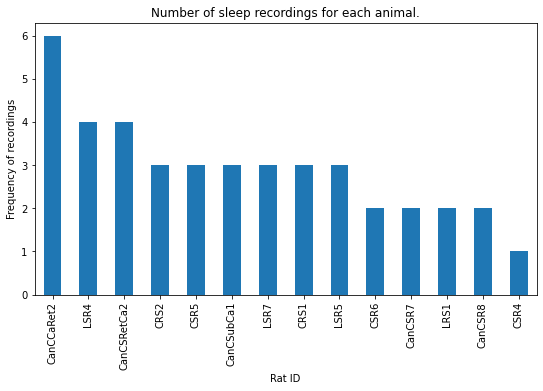

In [4]:
ax = sleep['rat'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of sleep recordings for each animal.")
ax.set_xlabel("Rat ID")
ax.set_ylabel("Frequency of recordings")
plt.show()

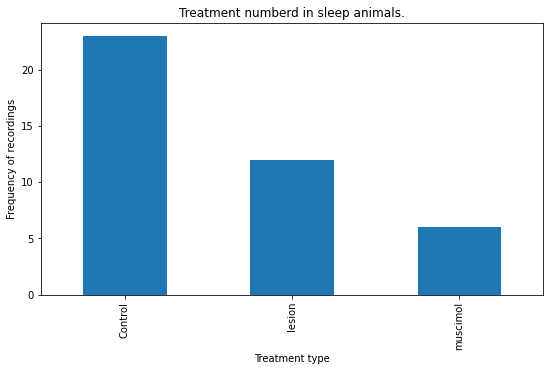

In [5]:
ax = sleep['treatment'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Treatment numberd in sleep animals.")
ax.set_xlabel("Treatment type")

ax.set_ylabel("Frequency of recordings")
plt.show()

##### **Auxiliary functions**

In [159]:
def bandpower(data, low, high, window_sec = 2, sf = 250, relative_power = True):
 
    from scipy.signal import welch
    from scipy.integrate import simps
    scale = 1000 
    lfp_samples = data * scale
    _filter = [1.5, 40]

    # Compute the modified periodogram (Welch)
    nperseg = int(window_sec * sf)
    freqs, psd = welch(lfp_samples, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's
    # rule)
    bp = simps(psd[idx_band], dx=freq_res)

    idx_band = np.logical_and(freqs >= _filter[0], freqs <= _filter[1])
    tp = simps(psd[idx_band], dx=freq_res)

    if relative_power:
        return bp / tp
    return bp


def bandpower_ratio(data, win_sec=2):
   
    b1 = bandpower(data, 1., 4., win_sec)
    b2 = bandpower(data, 5., 11., win_sec)
    if b1 == b2:
        print("Error!")
    bp = b1 / b2
    return bp


def mark_resting(file, mne_data,  tresh=2.5, window_sec = 2): # Mark timestamps were the speed > 2.5 cm/s
    ''' Returns ones for the time windows where the animal was moving with a speed smaller than treshold
    Inputs:
        file(str): filename to be analysed
        tresh(float): speed treshold in cm/s
        window_sec(int): Window in seconds to define resting epochs
    Returns: 
        resting(arr): 1 (ones) for resting 0 (zeros) for movement
    '''
    cnt = 0 # debug only
    #Calculate movement based on speed treshold
    file_resting = []
    
    pos = RecPos(file)
#     mne_data = mne_lfp_Axona(file)
    window = window_sec*250
    
    speed = pos.get_speed()
    moving = np.zeros(len(speed)*5)
    
    for i in range(0, len(speed)): 
        if speed[i] > tresh:
            moving[5*i:5*i+5] = 1
            
    for data in mne_data.get_data():
        result = np.zeros(len(data))
        for i in range(0, len(data) - window, window//2):
            bp = bandpower_ratio(data[i : i + window], window_sec)
            if sum(moving[i : i + window]) == 0 and bp < 2: # running speed < 2.5cm/s , and theta/delta power ratio < 2
                result[i : i + window] = 1 #ones for resting periods
#                 cnt+=1 # DEBUG
        file_resting.append(result)
#     print(f'Total epochs for window = {window_sec}s and tresh = {tresh}cm/s is: {cnt} epochs') # DEBUG
    return np.asarray(file_resting)

    
def create_events(record, events):
    '''Create events on MNE object
    Inputs:
        record(mne_object): recording to add events
        events_time(2D np array): array 0,1 with same lenght of recording dimension (1, lengt(record))
    output: 
    record(mne_object): Record with events added
    '''
    events = np.reshape(events, (1,-1))
    try:
        assert len(record.times) == events.shape[1]
        stim_data = events
        info = mne.create_info(['STI'], record.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        record.add_channels([stim_raw], force_update_info=True)
    except AssertionError as error:
        print(error)
        print('The lenght of events needs to be equal to record lenght.')
    return record

def process_spindles(mne_data):
    ''''''    
    sp = yasa.spindles_detect(mne_data, sf=250, thresh={'rel_pow': 0.2, 'corr': 0.65, 'rms': 2.5}, freq_sp= (12, 15), multi_only=True, verbose='error')
    df = sp.summary()
    return df

def spindles_exclude_resting(mne_data, resting, delta = 1):
    resting_df = pd.DataFrame(resting.T, columns = ['ch_'+str(1+i) for i in range(0, len(mne_data.info['ch_names']))])
    resting_df['time'] = [i*0.004 for i in range(0, len(mne_data))]
    resting_df = resting_df.set_index('time')
    spindles_df = process_spindles(mne_data)
    cnt = 0
    for channel in spindles_df.Channel.unique():  
        sp_times = spindles_df.loc[spindles_df.Channel == channel][['Start', 'End']].values
        for time in sp_times:
            try:
                if sum(resting_df[channel][time[0] : time[1]]):
                    spindles_df[(spindles_df.Channel == channel) & (spindles_df.Start == time[0]) & (spindles_df.End == time[1])] = np.nan
            except:
                print(f'Error in channel {channel}')
#     len_before = len(spindles_df)
#     spindles_df = spindles_df.dropna()
#     print(f'Number of filtered spindles: {len_before - len(spindles_df)}')
    return spindles_df

##### **Divide files into treatment groups**

In [7]:
musc = sleep.loc[sleep.treatment == 'muscimol']
control = sleep.loc[sleep.treatment == 'Control']
lesion = sleep.loc[sleep.treatment == 'lesion']
print(f'Muscimol: {len(musc)} recordings in {len(musc.rat.unique())} animals')
print(f'Control: {len(control)} recordings in {len(control.rat.unique())} animals')
print(f'Lesion: {len(lesion)} recordings in {len(lesion.rat.unique())} animals')
msc_files = sleep.loc[sleep.treatment == 'muscimol', ['folder', 'filename']].agg('/'.join, axis=1).values
cnt_files = sleep.loc[sleep.treatment == 'Control', ['folder', 'filename']].agg('/'.join, axis=1).values
les_files = sleep.loc[sleep.treatment == 'lesion', ['folder', 'filename']].agg('/'.join, axis=1).values

Muscimol: 6 recordings in 1 animals
Control: 23 recordings in 9 animals
Lesion: 12 recordings in 4 animals


#### **Debuging**

#### Test mark_resting function:


In [146]:
# file = cnt_files[0]

In [148]:
# mne_data = mne_lfp_Axona(file)
# m1 = mark_resting(file, mne_data, tresh=2.5, window_sec = 2) #(1 for rest, 0 for movement)
# m2 = mark_resting(file, mne_data, tresh=2.5, window_sec = 5)
# m3 = mark_resting(file, mne_data, tresh=4.5, window_sec = 2)

#### Test spindles_exclude_movement function:

In [151]:
# mne_data = mne_lfp_Axona(file)
# resting = mark_resting(file, mne_data, tresh=10.5, window_sec = 1)
# df_25 = (spindles_exclude_movement(mne_data, resting))
# resting1 = mark_resting(file, mne_data, tresh= 2.5, window_sec = 2)
# df_45 = (spindles_exclude_movement(mne_data, resting1))

Number of filtered spindles: 710
Number of filtered spindles: 674


In [78]:
resting_df = pd.DataFrame(resting.T, columns = ['ch_'+str(1+i) for i in range(0, len(mne_data.info['ch_names']))])
resting_df['time'] = [i*0.004 for i in range(0, len(mne_data))]
resting_df = resting_df.set_index('time')
spindles_df = process_spindles(mne_data)


In [160]:
dfs = []
for file in tqdm(cnt_files):
    mne_data = mne_lfp_Axona(file)
    resting = mark_resting(file, mne_data,  tresh=2.5, window_sec = 2)
    dfs.append(spindles_exclude_resting(mne_data, resting))
control_df = pd.concat(dfs)  

 30%|███       | 7/23 [03:54<08:53, 33.34s/it]

Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32
Error in channel ch_32


 39%|███▉      | 9/23 [05:00<07:42, 33.06s/it]

Error in channel ch_32


 78%|███████▊  | 18/23 [09:54<02:39, 31.92s/it]

Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31


 83%|████████▎ | 19/23 [10:23<02:04, 31.14s/it]

Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_31
Error in channel ch_32


100%|██████████| 23/23 [12:37<00:00, 32.92s/it]


In [161]:
dfs = []
for file in tqdm(msc_files):
    mne_data = mne_lfp_Axona(file)
    resting = mark_resting(file, mne_data,  tresh=2.5, window_sec = 2)
    dfs.append(spindles_exclude_resting(mne_data, resting))
musc_df = pd.concat(dfs)  

100%|██████████| 6/6 [03:19<00:00, 33.18s/it]


In [162]:
dfs = []
for file in tqdm(les_files):
    mne_data = mne_lfp_Axona(file)
    resting = mark_resting(file, mne_data,  tresh=2.5, window_sec = 2)
    dfs.append(spindles_exclude_resting(mne_data, resting))
lesion_df = pd.concat(dfs)  

 17%|█▋        | 2/12 [00:58<04:58, 29.86s/it]20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_17 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_18 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_19 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_20 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_21 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_22 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ERROR | Wrong data amplitude for ch_23 (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
20-May-21 16:40:22 | ER

In [163]:
profile_control = ProfileReport(control_df, title="Pandas Profiling Report")
profile_lesion = ProfileReport(lesion_df, title="Pandas Profiling Report")
profile_musc = ProfileReport(musc_df, title="Pandas Profiling Report")

In [164]:
profile_lesion.to_file("lesion1.html")
profile_musc.to_file("muscimol1.html")
profile_control.to_file("control1.html")

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ax = plt.figure(figsize=(12, 4))
plt.specgram(data[0:50000], NFFT=500, Fs=250., noverlap=250  ,cmap='jet_r')
plt.show()

In [ ]:
test_data = msc_files[0]
data = mne_lfp_Axona(test_data)
sp = yasa.spindles_detect(data, 250., ch_names=['ch_1'], thresh={'rel_pow': 0.2, 'corr': 0.65, 'rms': 2.5}, freq_sp= (12, 15), multi_only=True, verbose='error')

In [ ]:
df = sp.summary()

In [ ]:
ch1 = df.loc[df.Channel == 'ch_1']
ch2 = df.loc[df.Channel == 'ch_2']

In [ ]:
print(f'Ch1 oscilations mean: {ch1.Oscillations.mean():.2f}, std: {ch1.Oscillations.std():.2f}')
print(f'Ch2 oscilations mean: {ch2.Oscillations.mean():.2f}, std: {ch2.Oscillations.std():.2f}')

In [ ]:
ch4 = df.loc[df.Channel == 'ch_4']
ch5 = df.loc[df.Channel == 'ch_5']

In [ ]:
print(f'Ch4 oscilations mean: {ch4.Oscillations.mean():.2f}, std: {ch4.Oscillations.std():.2f}')
print(f'Ch5 oscilations mean: {ch5.Oscillations.mean():.2f}, std: {ch5.Oscillations.std():.2f}')

In [ ]:
sps = process_spindles(msc_files, channel_names = ['ch_1'])

In [ ]:
sps[0].summary()

In [ ]:
# Load the data
data = mne_lfp_Axona(sleep_files[13])
data = data.filter(l_freq=10, h_freq = 16,  method='fir',verbose=0).copy()

In [ ]:
data.info


**Spindle Detection and Verification** [https://academic.oup.com/sleep/article/39/5/1069/2454043?login=true#125103895]

We developed an algorithm to automatically detect sleep spindle events in line with previous studies.(20,39) LFP raw data was resampled to 1,000 Hz, band-pass filtered (using a zero-phase, second order, Infinite Impulse Response Butterworth filter) between 10–16 Hz and the instantaneous amplitude was extracted via the Hilbert transform. Then, two thresholds were set relatively to the mean band-pass signal during NREM sleep: (1) a “detection threshold” (+2 SD above the mean) identified events as potential spindles, and (2) a “noise threshold” (+0.2 SD above the mean) was used to define the start and end of sleep spindle event. To verify specificity for sleep spindles (versus broadband power increases), we excluded any putative spindle event whose instantaneous amplitude in a control frequency band (20–30 Hz) exceeded a predefined threshold of +4.5 SD above the mean. Finally an event qualified as a spindle if its duration was between 0.5 and 2.5 sec. It should be emphasized that the specific parameters of the spindle detection algorithm (e.g., frequency range, filter settings, thresholds) were optimized after extensive visual inspection to minimize false detections, and a wide range of parameters yielded similar detections and overall results (data not shown). Power spectral density (Figure 2B) was computed on 350-msec time windows centered on spindle peaks or random time-intervals in NREM sleep.

#### **Calculate Welch's PSD**

The gold-standard and most widely-used method to calculate the power spectral density (PSD) of EEG data is the Welch's sliding periodogram, which is implemented in SciPy.

The Welch's method improves the accuracy of the classic periodogram. The reason is simple: EEG data are always time-varying, meaning that if you look at a 30 seconds of EEG data, it is very (very) unlikely that the signal will looks like a perfect sum of pure sines. Rather, the spectral content of the EEG changes over time, constantly modified by the neuronal activity at play under the scalp. Problem is, to return a true spectral estimate, a classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance. By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution. The frequency resolution in Welch's method is defined by the window length, such that $F = 1 / t$, with $t$ being the window length in seconds. In other words, a 4-sec sliding window will give a frequency resolution of 1 / 4 = 0.25 Hz.

How do we define the optimal window duration then? A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest. So for instance, if our lowest frequency of interest is 1 Hz so we will choose a window of 2 / 1 = 2 seconds.

Note that in the code below, I use a median average of all the resulting sliding windows. Indeed, this may result in less biased and more accurate PSD as explained in this 